# LSTM Model

In [183]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from models.simple_LSTM import *
from models.train_LSTM import train, k_fold
from models.early_stopping import EarlyStopping
from data.LSTM_dataset import LSTMDataset
from models.metrics import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
import matplotlib

font = {'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (10, 5)


In [185]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load Dataset

In [186]:
torch.manual_seed(0)
np.random.seed(0)

dataset = LSTMDataset('../data',
                      max_length=4293)


data processing: 100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


In [187]:
dataset.features_selection = ['max_energies', 'N1']

In [188]:
size = int(len(dataset) * 0.9)

train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=128)
print(f'train size : {len(train_set)}, val size : {len(test_set)}')

train size : 84, val size : 10


In [179]:
# Used to compute Min Max of each feature for the normalization
# Don't forget to remove any normalization in the dataset to compute these values

# for key in dataset.features[0].keys():
#     feature = []
#     for idx in train_set.indices :
#         item = dataset.features[idx]
#         feature += item[key]
#     feature = np.array(feature)
#     print(f'key={key}, min={feature.min()}, max={feature.max()}')

key=max_energies, min=-85.96656799316406, max=0.0
key=N0, min=0.0, max=0.01933598518371582
key=N1, min=0.0, max=0.01427044253796339
key=N2, min=0.0, max=0.006555802654474974
key=N3, min=0.0, max=0.008545678108930588
key=N4, min=0.0, max=0.005050082691013813
key=LM, min=0.0, max=0.001794364652596414


## Compute `pos_weight`

We have a unbalanced dataset, to rebalance the dataset, we add a weight for positive value. The pos_weight is equal to $\frac{\text{total}}{\text{number of pos}} $

In [180]:
def compute_pos_weight(data):
    size = 0
    nb_pos = 0
    for item in data:
        labels = item[1]
        size += len(labels.flatten())
        nb_pos +=(labels == 1).sum()
    return size / nb_pos

compute_pos_weight(train_loader)

tensor(8.3106)

## Init Model

In [190]:
input_size = dataset[0][0].shape[1]
print(f'input_size={input_size}')
hidden_size = 8
num_layers = 1
lr = 0.001
weight_decay = 1e-06
l1_sigma = 1e-06
dropout_rate = 0

pos_weight = compute_pos_weight(train_loader) # size / # pos

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

patience=10
delta=1e-2
model_path = '../models/lstm.pt'
early_stopping = EarlyStopping(model_path, patience, delta)

print(model)    
print(optimizer)
print(criterion)
print(f'l1_sigma={l1_sigma}')
print(early_stopping)

input_size=2
The model has 393 trainable parameters
SimpleLSTM(
  (lstm): LSTM(2, 8, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-06
)
BCEWithLogitsLoss()
l1_sigma=1e-06
EarlyStopping(
    patience : 10
    delta : 0.01
)


## Model training

100%|██████████| 500/500 [01:20<00:00,  6.17it/s, score=0.434, train_loss=0.693]  


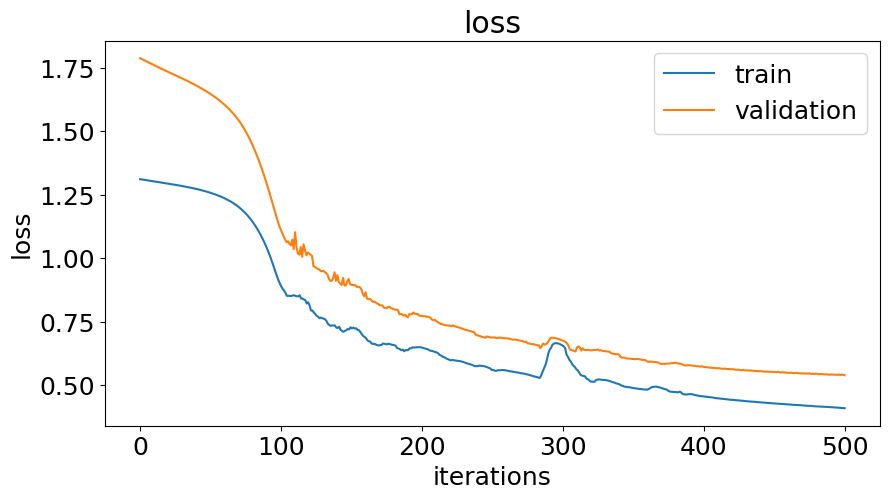

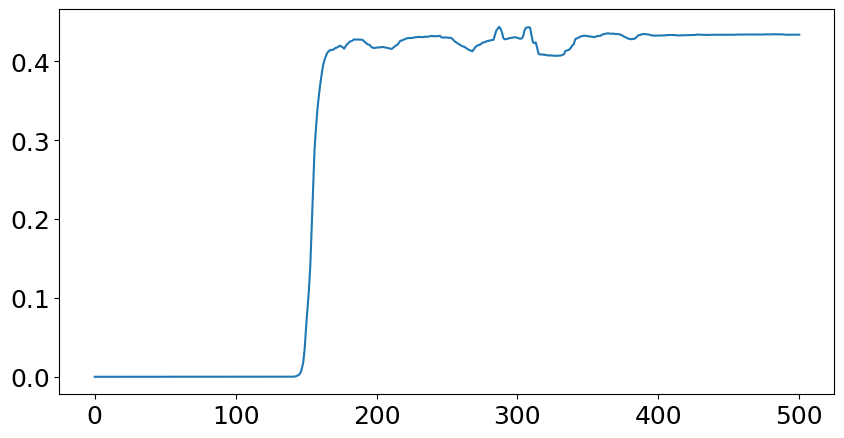

In [156]:
from data.LSTM_dataset import create_preds

def comptue_score(logits, labels):
      logits = torch.sigmoid(logits).detach()
      preds = create_preds(logits.unsqueeze(0)).to(device)
      return compute_f1(preds, labels)

train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      compute_score=comptue_score,
      n_epochs=500,
      l1_sigma=l1_sigma,
      # early_stopping=early_stopping)
      early_stopping=None)

## Model evaluation

f1=0.8896034359931946


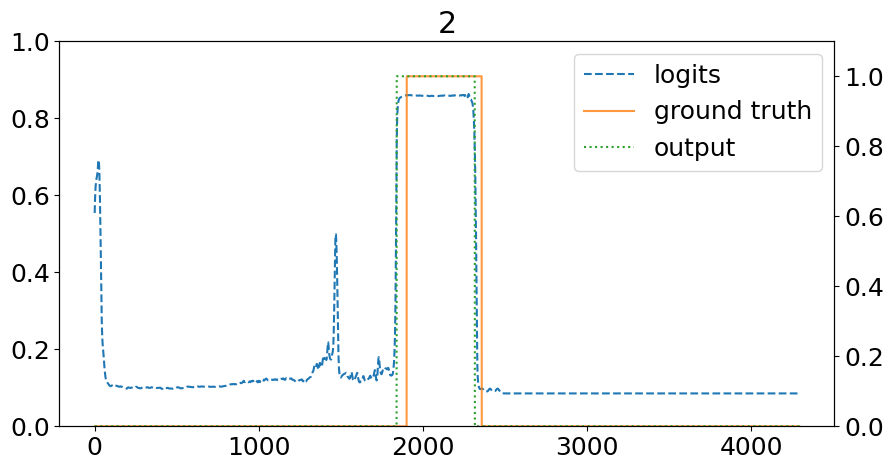

f1=0.62153160572052


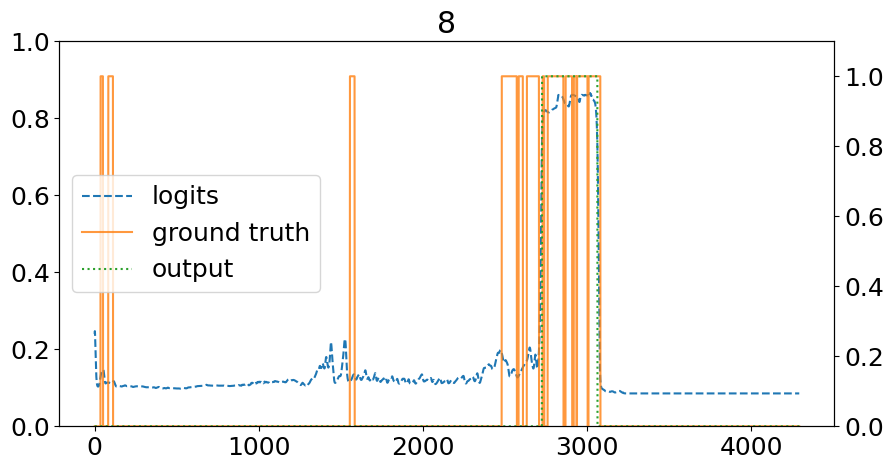

f1=0.8563758730888367


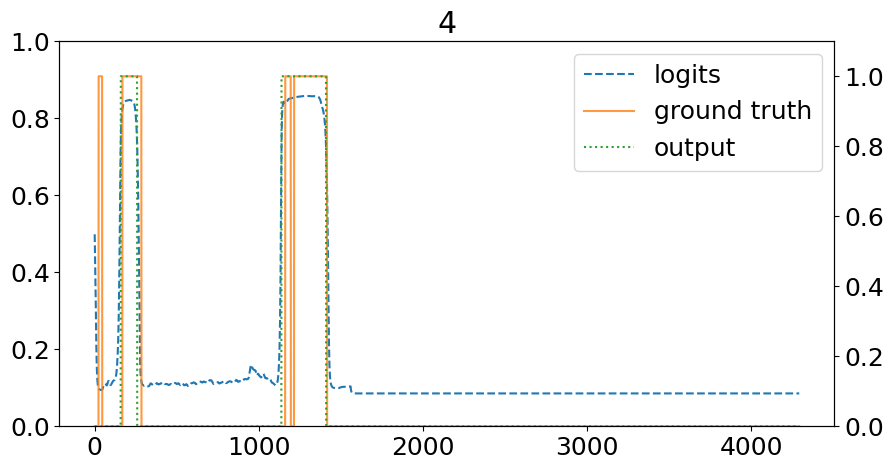

f1=0.3550087809562683


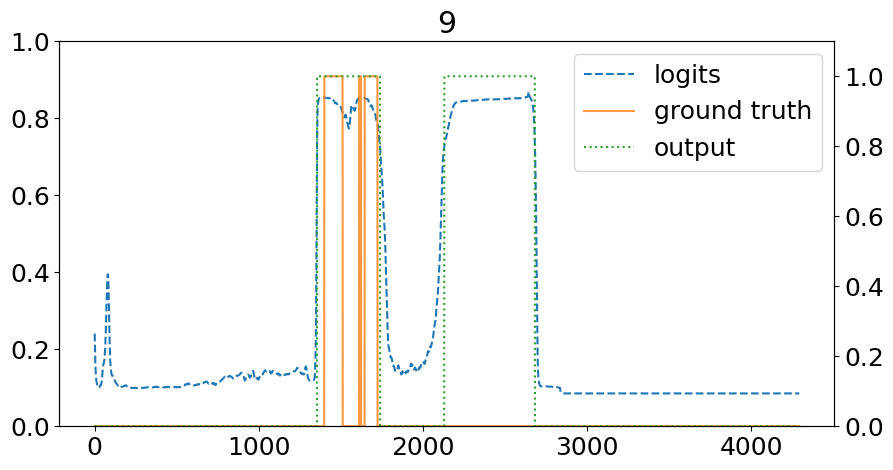

f1=0.6713781356811523


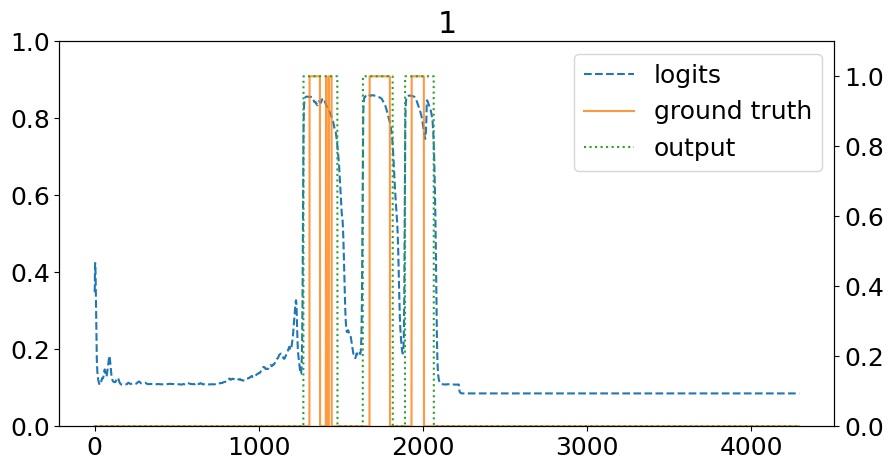

f1=0.9283124208450317


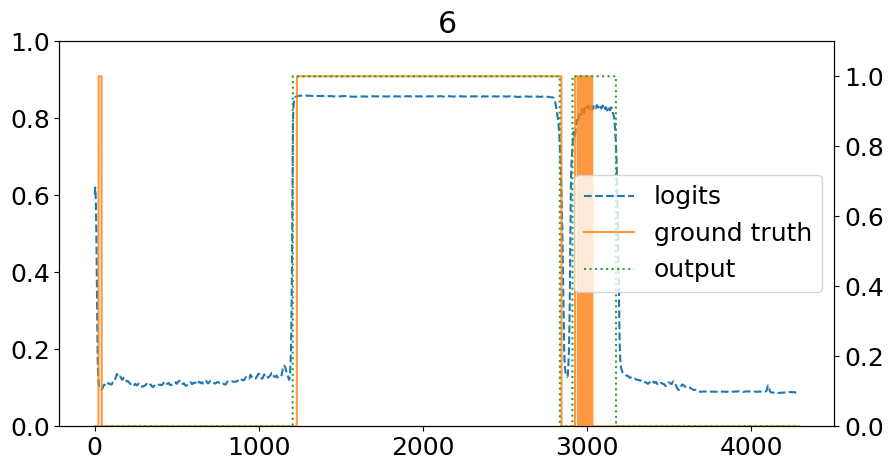

f1=0.3420523405075073


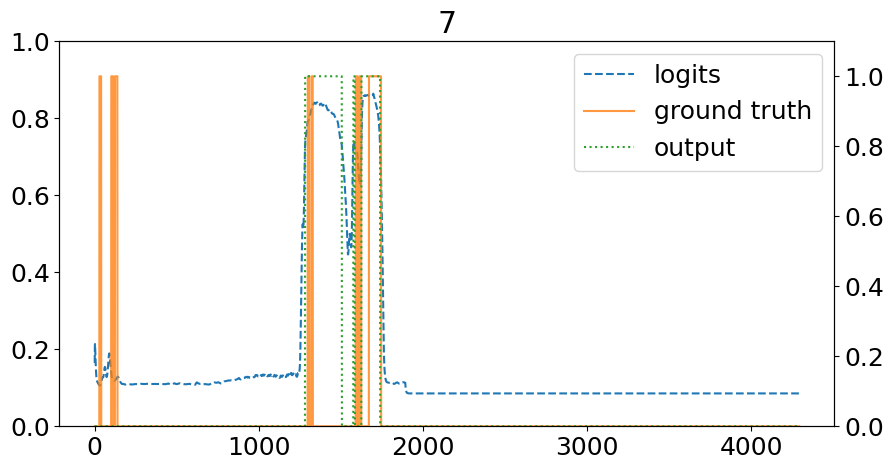

f1=0.8953880667686462


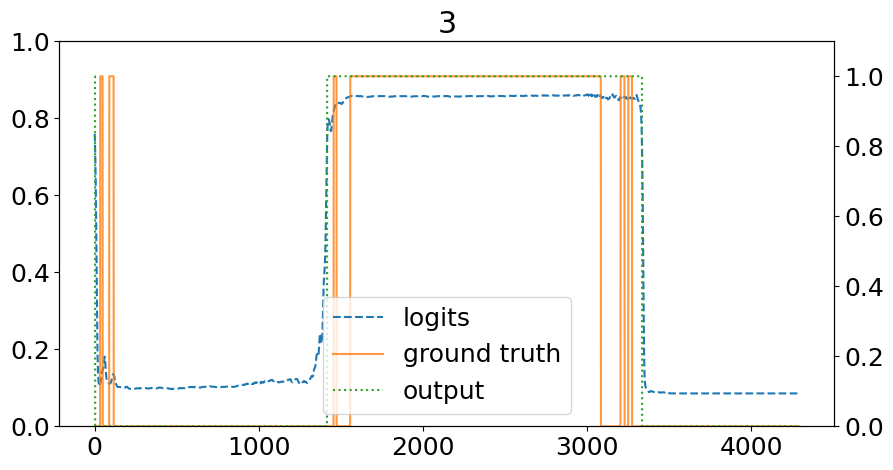

f1=0.9292073249816895


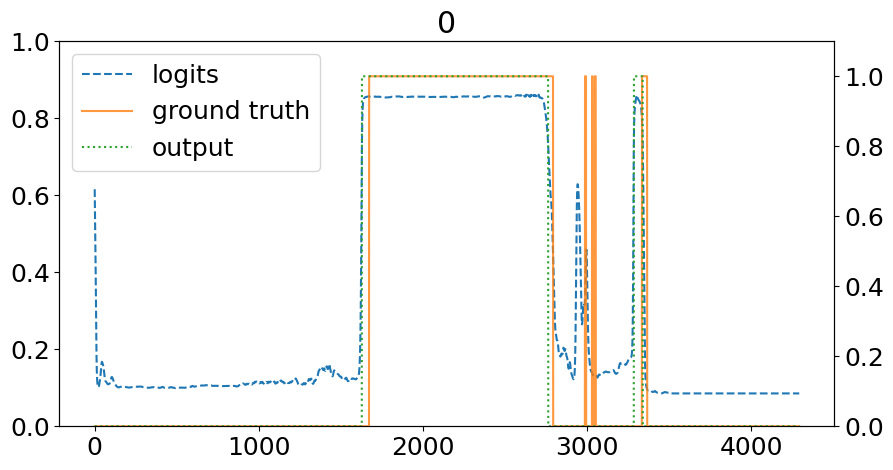

f1=0.9129464030265808


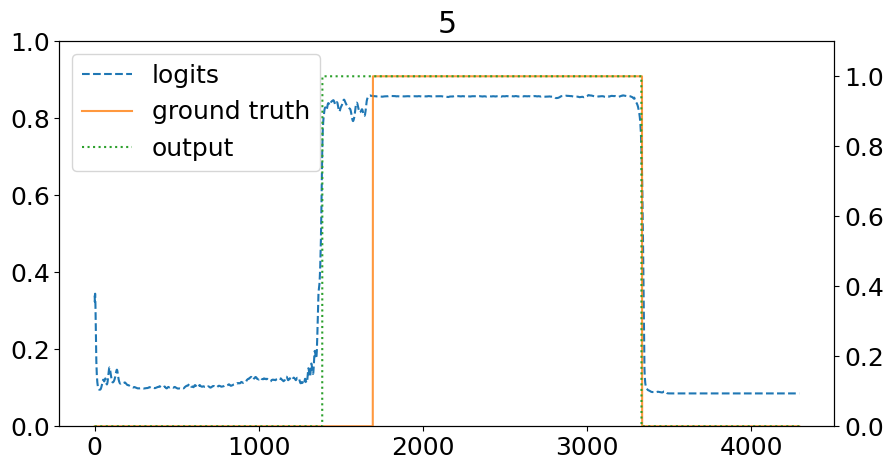

0.740256


In [157]:
import numpy as np
import matplotlib.pyplot as plt
from models.metrics import *


model.eval()
model.to(device)
with torch.no_grad():
    for idx in np.random.choice(len(test_set), len(test_set), replace=False): 
        testing_data = test_set[idx]
        logits = torch.sigmoid(model(testing_data[0].to(device))).detach().cpu()
        preds = create_preds(logits.unsqueeze(0))
        print(f'f1={compute_f1(preds == 1, testing_data[1].unsqueeze(0)).item()}')

        fig, ax = plt.subplots()

        plt.title(idx)
        ax1 = ax.twinx()
        ax1.plot(logits.numpy(), label='logits', linestyle='--' )
        ax1.plot(testing_data[1], label='ground truth', alpha=0.8)
        ax1.plot(preds.squeeze(), label='output', linestyle=':')
        # for idx in range(testing_data[0].shape[1]):
        #     data = testing_data[0][:,idx]
        #     if (data <= 0).all() :
        #         data *= -1
        #         ax.plot(testing_data[0][:,idx], alpha =0.3)
        #     else :
        #         ax.plot(testing_data[0][:,idx], alpha =0.3)
        # ax.plot(testing_data[0][:,0], label='max energies', alpha=0.3)
        # ax1.plot(testing_data[0][:,1], label='N1', alpha=0.3)
        ax1.legend()
        ax1.set_ylim(0, 1.1)
        plt.show()

    f1 = []

    for x_batch, y_batch in val_loader :
        x_batch = x_batch.to(device)
        
        logits = torch.sigmoid(model(x_batch)).detach().cpu()
        preds = create_preds(logits)

        f1 += compute_f1(preds, y_batch)

    print(np.mean(f1))

## Grid Search

In [191]:
import json
from tqdm import tqdm

k = 4
n_epochs = 500

search_res = []

best_hyper = None

hyperparams = []

input_size = dataset[0][0].shape[1]
lrs = [1e-3, 1e-4]
hidden_sizes = [4,2]
weight_decays =  [0,  1e-6]
l1_sigmas = [0, 1e-6]

for hidden_size in [16, 8]:        
    for lr in lrs:
        for weight_decay in weight_decays:
            for l1_sigma in l1_sigmas :
                hyperparams.append({'hidden_size' : hidden_size,
                                    'num_layers': 1,
                                    'dropout_rate': 0,
                                    'lr' : lr,
                                    'weight_decay' : weight_decay,
                                    'l1_sigma' : l1_sigma})

for hidden_size in hidden_sizes:
    for lr in lrs:
        for dropout_rate in [0, 0.2, 0.5]:
            for weight_decay in weight_decays:
                for l1_sigma in l1_sigmas :
                    hyperparams.append({'hidden_size' : hidden_size,
                                        'num_layers': 2,
                                        'dropout_rate':dropout_rate,
                                        'lr' : lr,
                                        'weight_decay' : weight_decay,
                                        'l1_sigma' : l1_sigma})
                    
for hidden_size in hidden_sizes:
    for lr in lrs:
            for weight_decay in weight_decays:
                for l1_sigma in l1_sigmas :
                    hyperparams.append({'hidden_size' : hidden_size,
                                        'num_layers': 1,
                                        'dropout_rate': 0,
                                        'lr' : lr,
                                        'weight_decay' : weight_decay,
                                        'l1_sigma' : l1_sigma})


with tqdm(hyperparams) as pbar :    
    for hyperparam in pbar:
        hidden_size = hyperparam['hidden_size']
        num_layers = hyperparam['num_layers']
        lr = hyperparam['lr']
        weight_decay = hyperparam['weight_decay']
        l1_sigma = hyperparam['l1_sigma']
        dropout_rate = hyperparam['dropout_rate']

        model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        metrics = k_fold(dataset, 
                         model, 
                         criterion, 
                         device, 
                         lr, 
                         weight_decay, 
                         create_preds,
                         k_fold=k, 
                         n_epochs=n_epochs, 
                         l1_sigma=l1_sigma, 
                         batch_size=128,  
                         disable_pbar=True)
                
        search_res.append( {'hidden_size' : hidden_size,
                'num_layers': num_layers,
                'lr' : lr,
                'dropout_rate' : dropout_rate,
                'weight_decay' : weight_decay,
                'l1_sigma' : l1_sigma,
                'metrics': metrics})

        if best_hyper is None or best_hyper['metrics']['f1'] < metrics['f1']:
            best_hyper = search_res[-1]

        pbar.set_postfix(hidden_size=hidden_size, 
                         num_layers=num_layers,
                         lr=lr, 
                         weight_decay=weight_decay,
                         l1_sigma=l1_sigma, 
                         dropout_rate=dropout_rate, 
                         f1=metrics["f1"], 
                         best_f1 = best_hyper['metrics']['f1'] if best_hyper is not None else 0)

        with open('grid_search.json', 'w', encoding='utf-8') as f:
            json.dump(search_res, f, indent=4)

        del model
        del criterion

print(best_hyper)

  9%|▉         | 7/80 [29:49<5:09:04, 254.03s/it, best_f1=0.166, dropout_rate=0, f1=0, hidden_size=16, l1_sigma=0, lr=0.0001, num_layers=1, weight_decay=1e-6]      

100%|██████████| 4/4 [07:44<00:00, 116.15s/fold]


{'accuracy': 0.2356528341770172, 'precision': 0.14914175868034363, 'recall': 0.19651082158088684, 'f1': 0.16292989253997803, 'kappa': 0.1549600064754486, 'train_loss': 0.6518955586403609, 'val_loss': 0.6704788160920143}
cuda


100%|██████████| 1500/1500 [04:02<00:00,  6.18it/s, score=0.456, train_loss=0.635] 


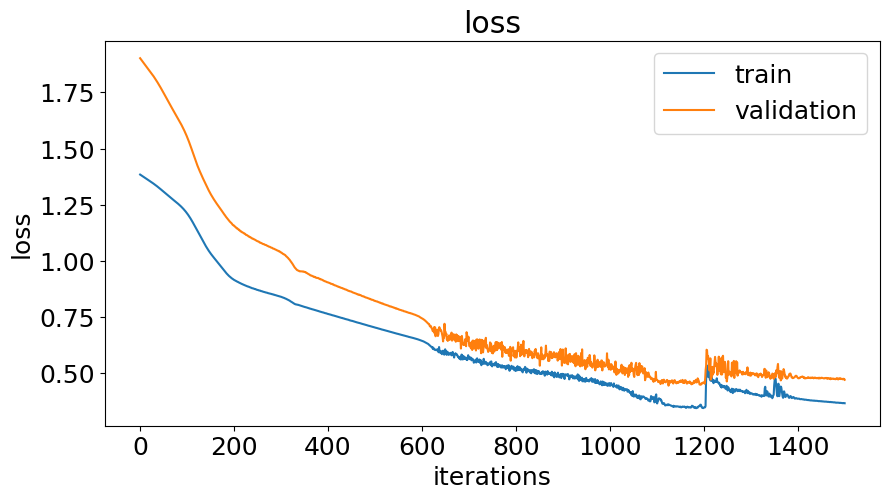

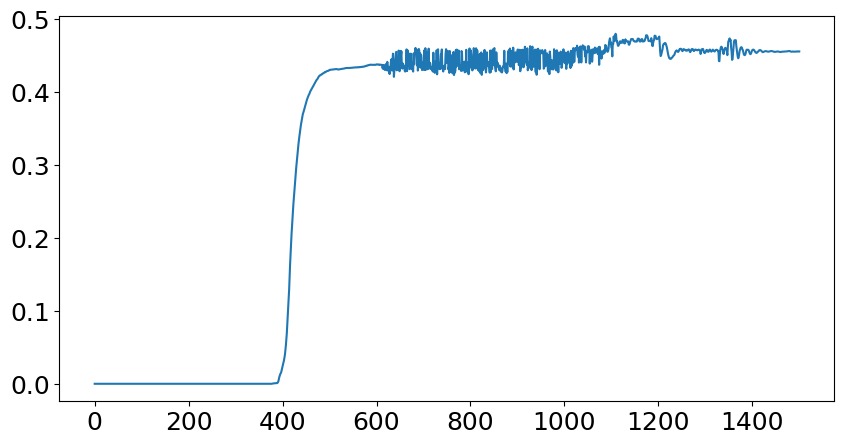

0.7450354


In [ ]:
k = 4
n_epochs = 1000

input_size = dataset[0][0].shape[1]
hidden_size = 8
num_layers = 1
lr = 0.001
weight_decay = 1e-06
l1_sigma = 1e-06
dropout_rate = 0

pos_weight = compute_pos_weight(train_loader)

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

metrics = k_fold(dataset, 
                 model, 
                 criterion, 
                 device, 
                 lr, 
                 weight_decay, 
                 create_preds,
                 k, 
                 n_epochs, 
                 l1_sigma, 
                 batch_size=128, 
                 patience=None, 
                 disable_pbar=False)

print(metrics)

def comptue_score(output, labels):
      logits = torch.sigmoid(output).detach()
      preds = create_preds(logits.unsqueeze(0)).to(device)
      return compute_f1(preds, labels)

model = SimpleLSTM(input_size, hidden_size, num_layers, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      compute_score=comptue_score,
      n_epochs=n_epochs,
      l1_sigma=l1_sigma,
      # early_stopping=early_stopping)
      early_stopping=None)

f1 = []

model.eval()
with torch.no_grad():
      for x_batch, y_batch in val_loader :
            x_batch = x_batch.to(device)
            
            logits = torch.sigmoid(model(x_batch)).detach().cpu()
            preds = create_preds(logits)

            f1 += compute_f1(preds, y_batch)

print(np.mean(f1))
